In [21]:
import os
import numpy as np
import cv2
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import time
from convnets_vir import (AlexNet, ResNet50, Xception, MobileNet_v2)

In [2]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('../input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'02_l': 0,
 '04_fist_moved': 1,
 '09_c': 2,
 '10_down': 3,
 '06_index': 4,
 '08_palm_moved': 5,
 '07_ok': 6,
 '05_thumb': 7,
 '01_palm': 8,
 '03_fist': 9}

In [3]:
reverselookup

{0: '02_l',
 1: '04_fist_moved',
 2: '09_c',
 3: '10_down',
 4: '06_index',
 5: '08_palm_moved',
 6: '07_ok',
 7: '05_thumb',
 8: '01_palm',
 9: '03_fist'}

In [4]:
x_data = []
y_data = []
IMG_SHAPE = (150, 150)
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('../input/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = '../input/leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, IMG_SHAPE)
                arr = np.array(img)
                x_data.append(arr) 
                count += 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount += count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

In [5]:
x_data.shape, y_data.shape

((20000, 150, 150), (20000, 1))

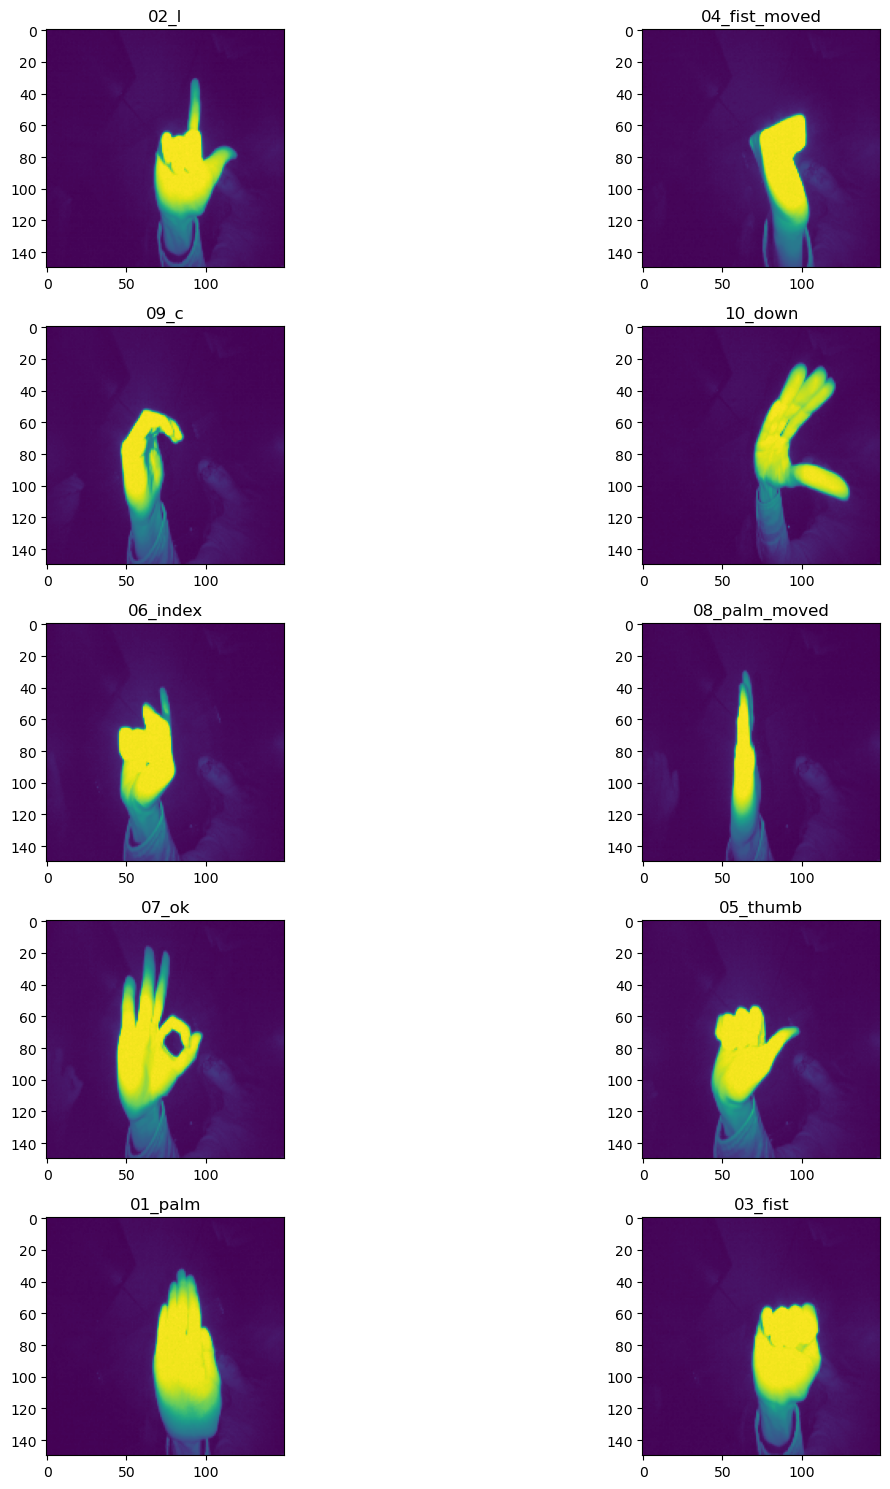

In [6]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
t = 0
for i in range(5):
    for j in range(2):
        ax[i, j].imshow(x_data[t*200])
        ax[i, j].set_title(reverselookup[t])
        t += 1
plt.tight_layout()
plt.show()

In [7]:
x_data = tf.expand_dims(x_data, -1)
y_data = tf.keras.utils.to_categorical(y_data)

In [8]:
x_data.shape, y_data.shape

(TensorShape([20000, 150, 150, 1]), (20000, 10))

In [9]:
x_data /= 255
img_shape = np.array(x_data.shape[1:])

In [10]:
Table = dict()
def addto(name, y_true, y_pred, tym):
    
    _accuracy = CategoricalAccuracy()
    _accuracy.update_state(y_true, y_pred)
    _accuracy = _accuracy.result().numpy()
    
    _precision = Precision()
    _precision.update_state(y_true, y_pred)
    _precision = _precision.result().numpy()
    
    _recall = Recall()
    _recall.update_state(y_true, y_pred)
    _recall = _recall.result().numpy()
    
    _f1score = 2 * (_precision * _recall) / (_precision + _recall)
    
    Table[name] = (_accuracy, _precision, _recall, _f1score, tym/60)
    

In [11]:
 def plot_metrics(name, history):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.title(name)
    plt.tight_layout()
    plt.show()

In [12]:
def draw_cm(y_true, y_pred):
    
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    ticks = list(reverselookup.values())
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index=ticks, columns=ticks)
    cm_sns = sns.heatmap(cm/np.sum(cm), cmap='Blues', annot=True, fmt='.2f')
    cm_sns.set_xlabel('predicted')
    cm_sns.set_ylabel('actual')
#     plt.figure(figsize=(40, 40))
    plt.tight_layout()
    plt.show()

In [13]:
X_train, X_tv, y_train, y_tv = train_test_split(x_data.numpy(), y_data, test_size=0.2, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_tv, y_tv, test_size=0.5, random_state=156)

del x_data
del y_data

In [14]:
X_train.shape, y_train.shape

((16000, 150, 150, 1), (16000, 10))

In [15]:
X_val.shape, y_val.shape

((2000, 150, 150, 1), (2000, 10))

In [16]:
X_test.shape, y_test.shape

((2000, 150, 150, 1), (2000, 10))

# AlexNet

In [17]:
model = AlexNet(img_shape=img_shape, classes=10)
model.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 96)        11616     
                                                                 
 batch_normalization (BatchN  (None, 35, 35, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       614400    
                                                                 
 batch_normalization_1 (Batc  (None, 17, 17, 256)      1024      
 hNormalization)                                                 
                                                           

In [18]:
model.compile(loss='categorical_crossentropy', 
               optimizer=Adam(),
               metrics=[CategoricalAccuracy()])

In [22]:
callbacks = [ModelCheckpoint("AlexNet_model.h5", save_best_only=True, verbose=1),
             EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
             ReduceLROnPlateau(patience=3, verbose=1)]

In [23]:
tyme = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=20, batch_size=32, callbacks=callbacks)
tyme = time.time()-tyme

Epoch 1/20
499/500 [============================>.] - ETA: 0s - loss: 0.8254 - categorical_accuracy: 0.8370
Epoch 1: val_loss improved from inf to 1.95064, saving model to AlexNet_model.h5
500/500 [==============================] - 19s 19ms/step - loss: 0.8237 - categorical_accuracy: 0.8374 - val_loss: 1.9506 - val_categorical_accuracy: 0.7575 - lr: 0.0010
Epoch 2/20
497/500 [============================>.] - ETA: 0s - loss: 0.2976 - categorical_accuracy: 0.9601
Epoch 2: val_loss improved from 1.95064 to 0.15821, saving model to AlexNet_model.h5
500/500 [==============================] - 10s 20ms/step - loss: 0.2962 - categorical_accuracy: 0.9603 - val_loss: 0.1582 - val_categorical_accuracy: 0.9710 - lr: 0.0010
Epoch 3/20
499/500 [============================>.] - ETA: 0s - loss: 0.1468 - categorical_accuracy: 0.9837
Epoch 3: val_loss improved from 0.15821 to 0.01434, saving model to AlexNet_model.h5
500/500 [==============================] - 9s 18ms/step - loss: 0.1465 - categorical_

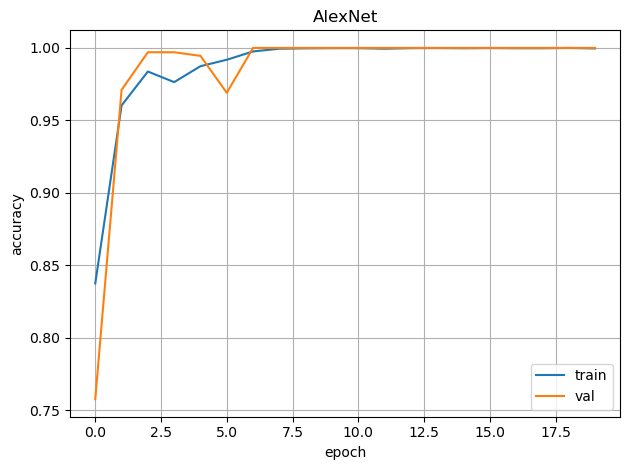

In [24]:
plot_metrics(model.name, history=history)

63/63 [==============================] - 1s 6ms/step


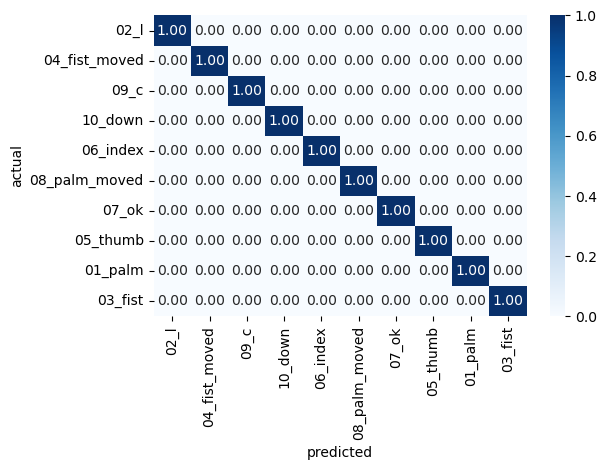

In [25]:
draw_cm(y_val, model.predict(X_val))

In [26]:
addto(model.name, y_test, model.predict(X_test), tyme)

63/63 [==============================] - 0s 5ms/step


# ResNet-50

In [27]:
model = ResNet50(img_shape=img_shape, classes=10)
model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 75, 75, 64)   3136        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 75, 75, 64)  256         ['conv2d_5[0][0]']        

In [28]:
model.compile(loss='categorical_crossentropy', 
               optimizer=Adam(),
               metrics=[CategoricalAccuracy()])

In [29]:
callbacks = [ModelCheckpoint("ResNet50_model.h5", save_best_only=True, verbose=1),
             EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
             ReduceLROnPlateau(patience=3, verbose=1)]

In [30]:
tyme = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=20, batch_size=32, callbacks=callbacks)
tyme = time.time() - tyme

Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 15.1588 - categorical_accuracy: 0.6649
Epoch 1: val_loss improved from inf to 10.60419, saving model to ResNet50_model.h5
500/500 [==============================] - 80s 105ms/step - loss: 15.1588 - categorical_accuracy: 0.6649 - val_loss: 10.6042 - val_categorical_accuracy: 0.4190 - lr: 0.0010
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 6.3189 - categorical_accuracy: 0.9350
Epoch 2: val_loss improved from 10.60419 to 5.16236, saving model to ResNet50_model.h5
500/500 [==============================] - 52s 103ms/step - loss: 6.3189 - categorical_accuracy: 0.9350 - val_loss: 5.1624 - val_categorical_accuracy: 0.7935 - lr: 0.0010
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 3.7016 - categorical_accuracy: 0.9616
Epoch 3: val_loss improved from 5.16236 to 4.21230, saving model to ResNet50_model.h5
500/500 [==============================] - 51s 101ms/step - loss: 3.7016 - 

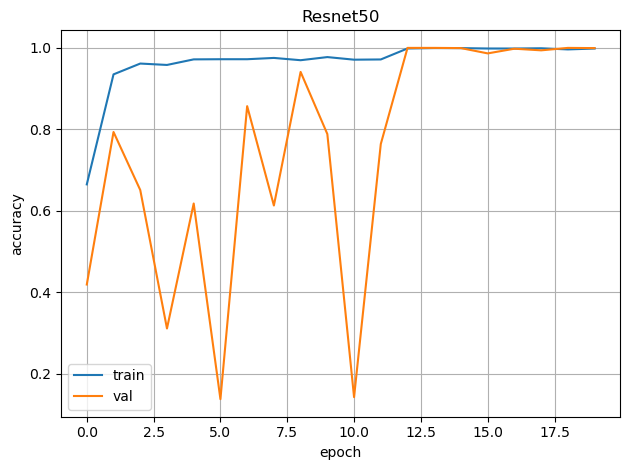

In [31]:
plot_metrics(model.name, history=history)

63/63 [==============================] - 3s 26ms/step


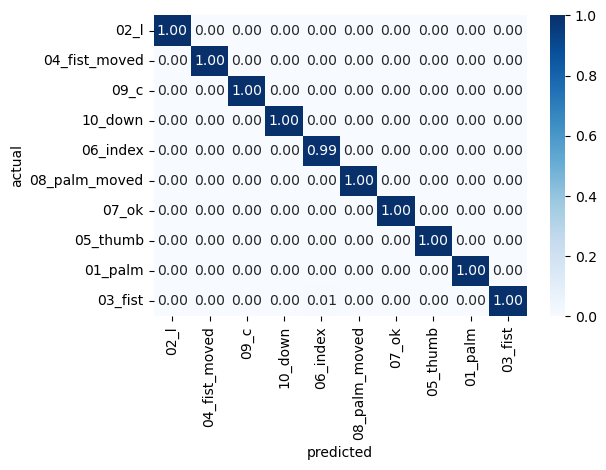

In [32]:
draw_cm(y_val, model.predict(X_val))

In [33]:
addto(model.name, y_test, model.predict(X_test), tyme)

63/63 [==============================] - 2s 26ms/step


# Xception Net

In [41]:
model = Xception(img_shape=img_shape, classes=10)
model.summary()


Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_115 (Conv2D)            (None, 75, 75, 32)   288         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_58 (BatchN  (None, 75, 75, 32)  128         ['conv2d_115[0][0]']             
 ormalization)                                                                                    
                                                                                           

In [42]:
model.compile(loss='categorical_crossentropy', 
               optimizer=Adam(),
               metrics=[CategoricalAccuracy()])

In [43]:
callbacks = [ModelCheckpoint("xception_model.h5", save_best_only=True, verbose=1),
             EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
             ReduceLROnPlateau(patience=3, verbose=1)]

In [44]:
tyme = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=15, batch_size=32, callbacks=callbacks)
tyme = time.time() - tyme

Epoch 1/15
500/500 [==============================] - ETA: 0s - loss: 0.1339 - categorical_accuracy: 0.9559
Epoch 1: val_loss improved from inf to 5.50542, saving model to xception_model.h5
500/500 [==============================] - 104s 156ms/step - loss: 0.1339 - categorical_accuracy: 0.9559 - val_loss: 5.5054 - val_categorical_accuracy: 0.1895 - lr: 0.0010
Epoch 2/15
500/500 [==============================] - ETA: 0s - loss: 0.0032 - categorical_accuracy: 0.9994
Epoch 2: val_loss improved from 5.50542 to 0.00436, saving model to xception_model.h5
500/500 [==============================] - 74s 148ms/step - loss: 0.0032 - categorical_accuracy: 0.9994 - val_loss: 0.0044 - val_categorical_accuracy: 0.9990 - lr: 0.0010
Epoch 3/15
500/500 [==============================] - ETA: 0s - loss: 0.0520 - categorical_accuracy: 0.9852
Epoch 3: val_loss did not improve from 0.00436
500/500 [==============================] - 73s 146ms/step - loss: 0.0520 - categorical_accuracy: 0.9852 - val_loss: 0.

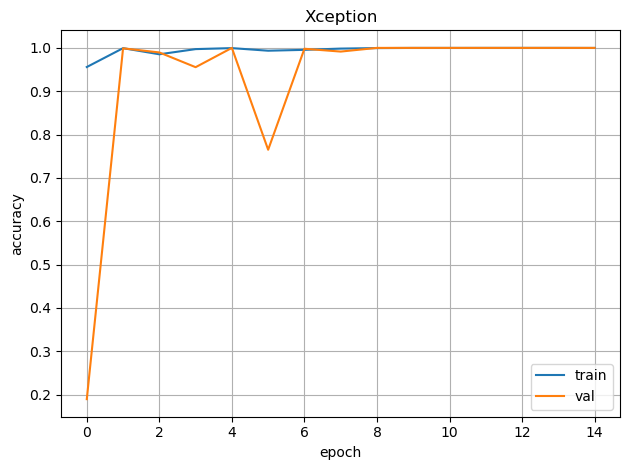

In [45]:
plot_metrics(model.name, history=history)

63/63 [==============================] - 3s 38ms/step


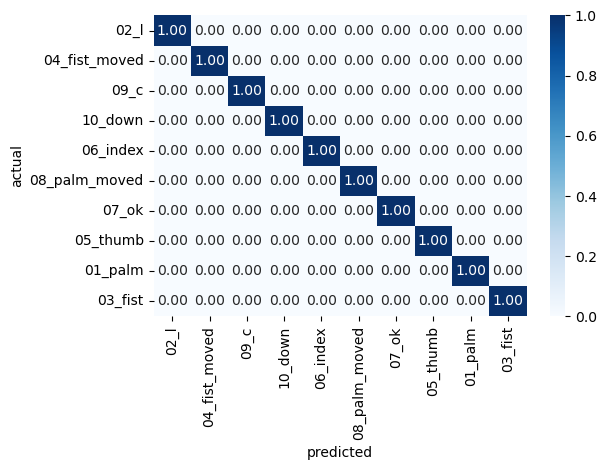

In [46]:
draw_cm(y_val, model.predict(X_val))

In [47]:
addto(model.name, y_test, model.predict(X_test), tyme)

63/63 [==============================] - 2s 39ms/step


# Mobile Net -v2

In [48]:
model = MobileNet_v2(img_shape=img_shape, classes=10)
model.summary()

Model: "MobieNetV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_121 (Conv2D)            (None, 74, 74, 32)   288         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_98 (BatchN  (None, 74, 74, 32)  128         ['conv2d_121[0][0]']             
 ormalization)                                                                                    
                                                                                         

In [49]:
model.compile(loss='categorical_crossentropy', 
               optimizer=Adam(),
               metrics=[CategoricalAccuracy()])

In [50]:
callbacks = [ModelCheckpoint("mobilenetv2_model.h5", save_best_only=True, verbose=1),
             EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
             ReduceLROnPlateau(patience=3, verbose=1)]

In [51]:
tyme = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=15, batch_size=32, callbacks=callbacks)
tyme = time.time() - tyme

Epoch 1/15


2023-03-30 11:02:32.242034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inMobieNetV2/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - ETA: 0s - loss: 0.2076 - categorical_accuracy: 0.9333
Epoch 1: val_loss improved from inf to 8.62432, saving model to mobilenetv2_model.h5
500/500 [==============================] - 70s 82ms/step - loss: 0.2076 - categorical_accuracy: 0.9333 - val_loss: 8.6243 - val_categorical_accuracy: 0.0880 - lr: 0.0010
Epoch 2/15
500/500 [==============================] - ETA: 0s - loss: 0.0331 - categorical_accuracy: 0.9895
Epoch 2: val_loss improved from 8.62432 to 0.23120, saving model to mobilenetv2_model.h5
500/500 [==============================] - 40s 81ms/step - loss: 0.0331 - categorical_accuracy: 0.9895 - val_loss: 0.2312 - val_categorical_accuracy: 0.9265 - lr: 0.0010
Epoch 3/15
500/500 [==============================] - ETA: 0s - loss: 0.0399 - categorical_accuracy: 0.9877
Epoch 3: val_loss did not improve from 0.23120
500/500 [==============================] - 39s 78ms/step - loss: 0.0399 - categorical_accuracy: 0.9877 - val_loss: 1.1636 - va

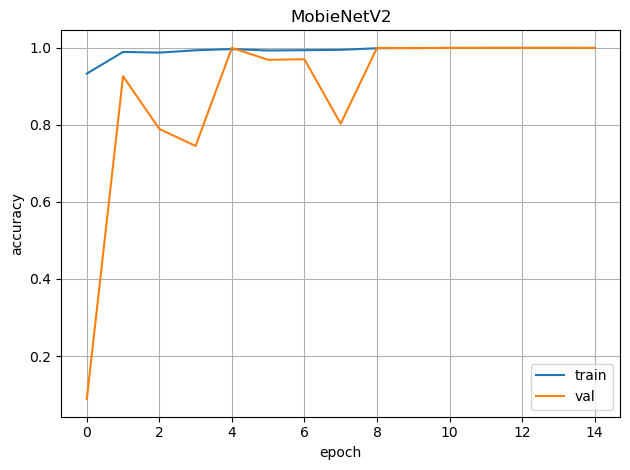

In [52]:
plot_metrics(model.name, history=history)

63/63 [==============================] - 2s 13ms/step


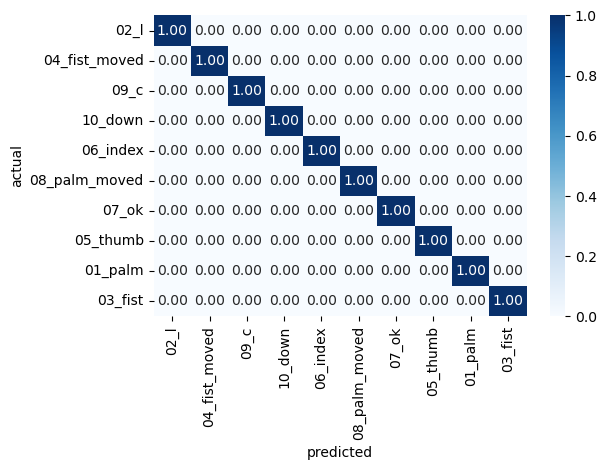

In [53]:
draw_cm(y_val, model.predict(X_val))

In [54]:
addto(model.name, y_test, model.predict(X_test), tyme)

63/63 [==============================] - 1s 13ms/step


## Analysis

In [60]:
pd.DataFrame(Table, index=['accuracy' ,'precision', 'recall', 'f1score', 'training time (in min)'])

,AlexNet,Resnet50,Xception,MobieNetV2
accuracy,0.999500,0.998500,0.999000,1.000000
precision,0.999500,0.998500,0.999000,1.000000
recall,0.999500,0.998500,0.999000,1.000000
f1score,0.999500,0.998500,0.999000,1.000000
training time (in min),3.441327,17.438121,18.941858,10.628391
